In [1]:
import pandas as pd
from sklearn import preprocessing
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn import ensemble
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.simplefilter(action = "ignore")

In [2]:
animals = pd.read_csv("train.csv")
animals_test = pd.read_csv("test.csv")

In [3]:
"""
Purpose: An animal comes in, how can we help it?

Questions to answer:
1)Is there a difference in outcomes between cats and dogs?
    Dogs more likely to be returned to owner
    Death and euthanasia rare for both
    
2)Does the sex or the sterilization state affect the outcome?
    It seems more likely to get adobted if Neutered or spayed: Action point!
    
3)Are there any seasonal trends?
    It is quiet time for cats in the first quarter of the year
    More adoptions in December and January for dogs
    
4)Does it matter if they have a name?
    Much more likley to get adopted or returned to owner if named. Maybe easier to connect with an animal that has a name?

5)Does age matter?
    Younger cats more likely to be adopted, small chance of return to owner (Where they maybe born in shelter?)
    Older dogs more likely to be euthanised
    Older dogs more likely to return to owner (they have had time to bond with it?)
    
    
Future questions to answer:
1)How about intake data? Which feature of the animals makes it more likely to find itself in a shelter?
2)Does breed affect outcome?
3)1 vs all: adoption and return_to_owner vs the rest
"""

'\nPurpose: An animal comes in, how can we help it?\n\nQuestions to answer:\n1)Is there a difference in outcomes between cats and dogs?\n    Dogs more likely to be returned to owner\n    Death and euthanasia rare for both\n    \n2)Does the sex or the sterilization state affect the outcome?\n    It seems more likely to get adobted if Neutered or spayed: Action point!\n    \n3)Are there any seasonal trends?\n    It is quiet time for cats in the first quarter of the year\n    More adoptions in December and January for dogs\n    \n4)Does it matter if they have a name?\n    Much more likley to get adopted or returned to owner if named. Maybe easier to connect with an animal that has a name?\n\n5)Does age matter?\n    Younger cats more likely to be adopted, small chance of return to owner (Where they maybe born in shelter?)\n    Older dogs more likely to be euthanised\n    Older dogs more likely to return to owner (they have had time to bond with it?)\n    \n    \nFuture questions to answer:

In [4]:
print(animals.describe())

       AnimalID   Name             DateTime OutcomeType OutcomeSubtype  \
count     26729  19038                26729       26729          13117   
unique    26729   6374                22918           5             16   
top     A705677    Max  2015-08-11 00:00:00    Adoption        Partner   
freq          1    136                   19       10769           7816   

       AnimalType SexuponOutcome AgeuponOutcome                   Breed  \
count       26729          26728          26711                   26729   
unique          2              5             44                    1380   
top           Dog  Neutered Male         1 year  Domestic Shorthair Mix   
freq        15595           9779           3969                    8810   

              Color  
count         26729  
unique          366  
top     Black/White  
freq           2824  


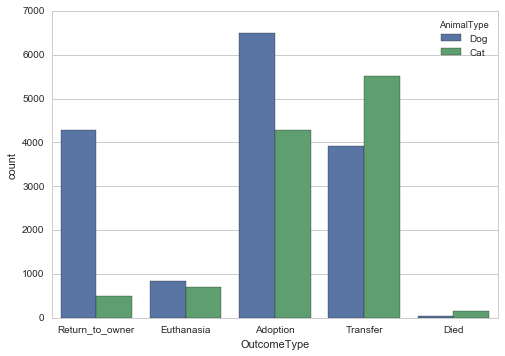

In [5]:
#Is there a difference in outcomes between cats and dogs?


sns.countplot(data=animals, x='OutcomeType',hue='AnimalType')
#Dogs more likely to be returned to owner
#Death is pretty rare

In [6]:
#Now some feature engineering

In [7]:
def get_year(dateTime):
    dateTime = str(dateTime)
    calen = dateTime.split(' ')[0]
    year = int(calen.split('-')[0])
    return year

def get_month(dateTime):
    dateTime = str(dateTime)
    calen = dateTime.split(' ')[0]
    month = int(calen.split('-')[1])
    return month

def get_day(dateTime):
    dateTime = str(dateTime)
    calen = dateTime.split(' ')[0]
    day = int(calen.split('-')[2])
    return day

    
animals['OutcomeYear'] = animals.DateTime.apply(get_year)
animals['OutcomeMonth'] = animals.DateTime.apply(get_month)
animals['OutcomeDay'] = animals.DateTime.apply(get_day)
animals = animals.drop('DateTime', 1)
#Now repeat operations for test set

animals_test['OutcomeYear'] = animals_test.DateTime.apply(get_year)
animals_test['OutcomeMonth'] = animals_test.DateTime.apply(get_month)
animals_test['OutcomeDay'] = animals_test.DateTime.apply(get_day)
animals_test = animals_test.drop('DateTime', 1)

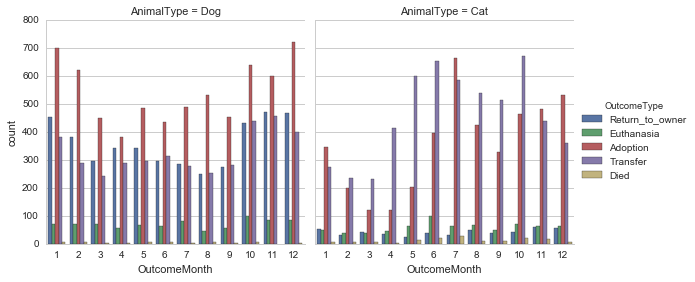

In [8]:
#Is there a seasonal trend?

sns.factorplot(x="OutcomeMonth",hue='OutcomeType',data=animals,col='AnimalType',kind='count',x_order=np.arange(1,13,1),legend=True)
sns.despine()



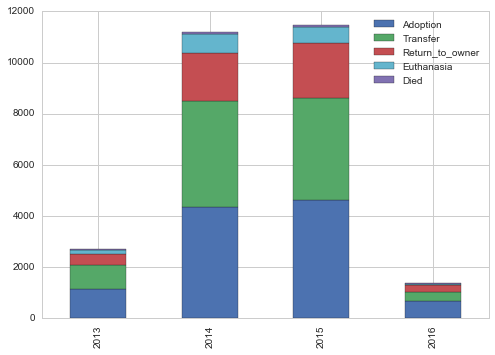

In [9]:
ret_yr = animals[animals['OutcomeYear']==2013]['OutcomeType'].value_counts()
euth_yr = animals[animals['OutcomeYear']==2014]['OutcomeType'].value_counts()
adop_yr = animals[animals['OutcomeYear']==2015]['OutcomeType'].value_counts()
trans_yr = animals[animals['OutcomeYear']==2016]['OutcomeType'].value_counts()


df = pd.DataFrame([ret_yr,euth_yr,adop_yr,trans_yr])
df.index = ['2013','2014','2015','2016']
df.plot(kind='bar',stacked=True)



In [10]:
print(animals.describe())

        OutcomeYear  OutcomeMonth    OutcomeDay
count  26729.000000  26729.000000  26729.000000
mean    2014.430731      6.925736     15.698343
std        0.741408      3.495869      8.770496
min     2013.000000      1.000000      1.000000
25%     2014.000000      4.000000      8.000000
50%     2014.000000      7.000000     16.000000
75%     2015.000000     10.000000     23.000000
max     2016.000000     12.000000     31.000000


In [11]:
#Split the 'SexuponOutcome' feature into two: Sterilization status and sex.
print(animals["SexuponOutcome"].unique())
animals['Sterilization'], animals['Sex'] = animals['SexuponOutcome'].str.split(' ', 1).str
animals = animals.drop('SexuponOutcome', 1)
animals["Sterilization"] = animals["Sterilization"].fillna('Unknown')


#And now to the test set
animals_test['Sterilization'], animals_test['Sex'] = animals_test['SexuponOutcome'].str.split(' ', 1).str
animals_test = animals_test.drop('SexuponOutcome', 1)
animals_test["Sterilization"] = animals_test["Sterilization"].fillna('Unknown')


['Neutered Male' 'Spayed Female' 'Intact Male' 'Intact Female' 'Unknown'
 nan]


In [12]:
#Fill unknown Sex entries with the most common one
animals["Sex"] = animals["Sex"].fillna(animals["Sex"].value_counts().idxmax())
print(animals["Sterilization"].unique())
print(animals["Sex"].unique())

#And now to the test set
animals_test["Sex"] = animals_test["Sex"].fillna(animals["Sex"].value_counts().idxmax())


['Neutered' 'Spayed' 'Intact' 'Unknown']
['Male' 'Female']


In [13]:
#Neutered and spayed are the same, just for different genders so combine them
def combine_sterilized(ster):
    ster = str(ster)
    if ster == 'Neutered' or ster =='Spayed':
        return 1
    elif ster == 'Intact':
        return 0
    else:
        return 2
    
animals['Sterilization'] = animals.Sterilization.apply(combine_sterilized)

#And now to the test set
animals_test['Sterilization'] = animals_test.Sterilization.apply(combine_sterilized)


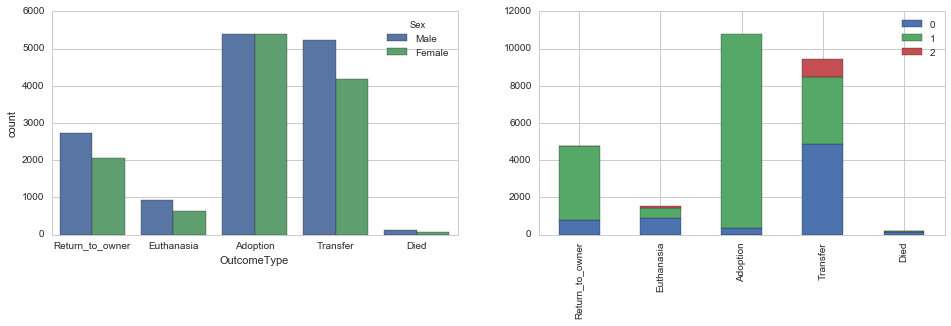

In [14]:
#Does the sex or the sterilization state affect the outcome?
ret_ster = animals[animals['OutcomeType']=='Return_to_owner']['Sterilization'].value_counts()
euth_ster = animals[animals['OutcomeType']=='Euthanasia']['Sterilization'].value_counts()
adop_ster = animals[animals['OutcomeType']=='Adoption']['Sterilization'].value_counts()
trans_ster = animals[animals['OutcomeType']=='Transfer']['Sterilization'].value_counts()
dies_ster = animals[animals['OutcomeType']=='Died']['Sterilization'].value_counts()

df = pd.DataFrame([ret_ster,euth_ster,adop_ster,trans_ster,dies_ster])
df.index = ['Return_to_owner','Euthanasia','Adoption','Transfer','Died']


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=animals, x='OutcomeType',hue='Sex', ax=ax1)
#sns.countplot(data=animals, x='OutcomeType',hue='Sterilization', ax=ax2)
df.plot(kind='bar',stacked=True, ax=ax2)
#It seems more likely to get adobted if Neutered or spayed: Action point!

In [15]:
#unify the 'Age' feature, now its a mixture of units
def convert_to_days(age_mix):
    age_mix = str(age_mix)
    if age_mix == 'nan': return 0
    val = int(age_mix.split(' ', 1)[0])
    unit = age_mix.split(' ', 1)[1]
    if unit.startswith('day'):
        return (val)
    elif unit.startswith('week'):
        return (val)*7
    elif unit.startswith('month'):
        return (val)*30
    elif unit.startswith('year'):
        return (val)*365
    

In [16]:
animals['AgeInDays'] = animals.AgeuponOutcome.apply(convert_to_days)
animals = animals.drop('AgeuponOutcome', 1)

#And now to the test set
animals_test['AgeInDays'] = animals_test.AgeuponOutcome.apply(convert_to_days)
animals_test = animals_test.drop('AgeuponOutcome', 1)

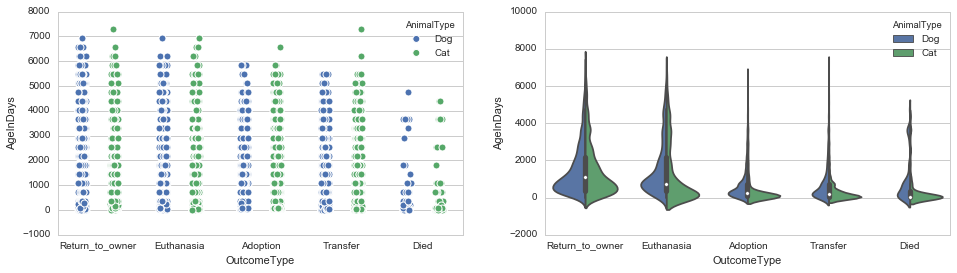

In [17]:
#Does age matter?
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

sns.stripplot(x="OutcomeType", y="AgeInDays", data=animals, hue=animals.AnimalType, jitter=True, ax=ax1)
sns.violinplot(x="OutcomeType", y="AgeInDays", data=animals, hue=animals.AnimalType, bw=.2,ax=ax2,split=True);

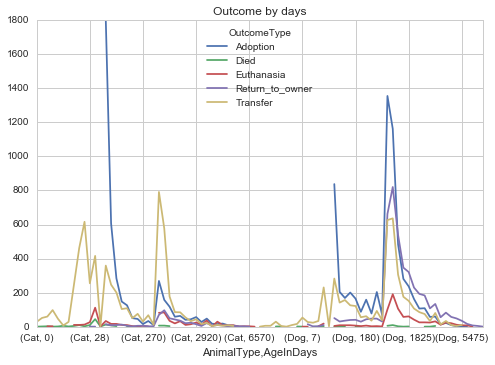

In [18]:
f = plt.figure(figsize=(13, 8))

animals[['AnimalType','AgeInDays','OutcomeType']].groupby(['AnimalType','AgeInDays','OutcomeType']).size().unstack().plot(title="Outcome by days")


In [19]:
#Make a new feature for whether the breed is mixed or not. This is signified by either the word 'mix' or a front slash
def is_mix_breed(breed_mix):
    breed_mix = str(breed_mix)
    if breed_mix.endswith('Mix'):
        return 1
    elif breed_mix.find('/')>0:
        return 1
    else:
        return 0
animals['Mix'] = animals.Breed.apply(is_mix_breed)

#And now to the test set
animals_test['Mix'] = animals_test.Breed.apply(is_mix_breed)

In [20]:
#Just diagnostic, Find how many unique purebreds there are. Not using this.
def find_pure_breed(breed_mix):
    breed_mix = str(breed_mix)
    if breed_mix.endswith('Mix'):
        return
    elif breed_mix.find('/')>0:
        return
    else:
        return breed_mix
purebreds=[]
purebreds_tmp = (animals.Breed.apply(find_pure_breed))
for i in purebreds_tmp:
    if i not in purebreds and i is not None:
        purebreds.append(i)
print len(purebreds) 

139


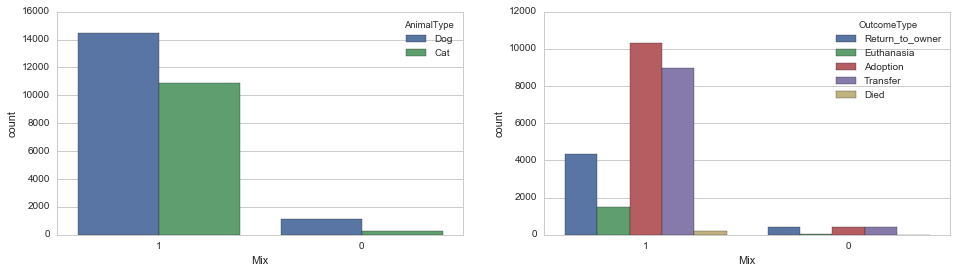

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=animals, x='Mix',hue='AnimalType', ax=ax1)
sns.countplot(data=animals, x='Mix',hue='OutcomeType', ax=ax2)

In [22]:
#Convert dog breed to dog group in order to cut down on the number of breeds while still retaining enough information.
#Data taken from https://www.kaggle.com/andraszsom/shelter-animal-outcomes/dog-breeds-dog-groups/notebook
#data originally scraped from https://en.wikipedia.org/wiki/List_of_dog_breeds_recognized_by_the_American_Kennel_Club
#Must add pit bull seperately because its not in the list of groups
#If the dog is a mix, the first part is only taken into account, this could be improved!

breeds = ['Blue Lacy','Queensland Heeler','Rhod Ridgeback','Retriever','Chinese Sharpei','Black Mouth Cur','Catahoula','Staffordshire','Affenpinscher','Afghan Hound','Airedale Terrier','Akita','Australian Kelpie','Alaskan Malamute','English Bulldog','American Bulldog','American English Coonhound','American Eskimo Dog (Miniature)','American Eskimo Dog (Standard)','American Eskimo Dog (Toy)','American Foxhound','American Hairless Terrier','American Staffordshire Terrier','American Water Spaniel','Anatolian Shepherd Dog','Australian Cattle Dog','Australian Shepherd','Australian Terrier','Basenji','Basset Hound','Beagle','Bearded Collie','Beauceron','Bedlington Terrier','Belgian Malinois','Belgian Sheepdog','Belgian Tervuren','Bergamasco','Berger Picard','Bernese Mountain Dog','Bichon Fris_','Black and Tan Coonhound','Black Russian Terrier','Bloodhound','Bluetick Coonhound','Boerboel','Border Collie','Border Terrier','Borzoi','Boston Terrier','Bouvier des Flandres','Boxer','Boykin Spaniel','Briard','Brittany','Brussels Griffon','Bull Terrier','Bull Terrier (Miniature)','Bulldog','Bullmastiff','Cairn Terrier','Canaan Dog','Cane Corso','Cardigan Welsh Corgi','Cavalier King Charles Spaniel','Cesky Terrier','Chesapeake Bay Retriever','Chihuahua','Chinese Crested Dog','Chinese Shar Pei','Chinook','Chow Chow',"Cirneco dell'Etna",'Clumber Spaniel','Cocker Spaniel','Collie','Coton de Tulear','Curly-Coated Retriever','Dachshund','Dalmatian','Dandie Dinmont Terrier','Doberman Pinsch','Doberman Pinscher','Dogue De Bordeaux','English Cocker Spaniel','English Foxhound','English Setter','English Springer Spaniel','English Toy Spaniel','Entlebucher Mountain Dog','Field Spaniel','Finnish Lapphund','Finnish Spitz','Flat-Coated Retriever','French Bulldog','German Pinscher','German Shepherd','German Shorthaired Pointer','German Wirehaired Pointer','Giant Schnauzer','Glen of Imaal Terrier','Golden Retriever','Gordon Setter','Great Dane','Great Pyrenees','Greater Swiss Mountain Dog','Greyhound','Harrier','Havanese','Ibizan Hound','Icelandic Sheepdog','Irish Red and White Setter','Irish Setter','Irish Terrier','Irish Water Spaniel','Irish Wolfhound','Italian Greyhound','Japanese Chin','Keeshond','Kerry Blue Terrier','Komondor','Kuvasz','Labrador Retriever','Lagotto Romagnolo','Lakeland Terrier','Leonberger','Lhasa Apso','L_wchen','Maltese','Manchester Terrier','Mastiff','Miniature American Shepherd','Miniature Bull Terrier','Miniature Pinscher','Miniature Schnauzer','Neapolitan Mastiff','Newfoundland','Norfolk Terrier','Norwegian Buhund','Norwegian Elkhound','Norwegian Lundehund','Norwich Terrier','Nova Scotia Duck Tolling Retriever','Old English Sheepdog','Otterhound','Papillon','Parson Russell Terrier','Pekingese','Pembroke Welsh Corgi','Petit Basset Griffon Vend_en','Pharaoh Hound','Plott','Pointer','Polish Lowland Sheepdog','Pomeranian','Standard Poodle','Miniature Poodle','Toy Poodle','Portuguese Podengo Pequeno','Portuguese Water Dog','Pug','Puli','Pyrenean Shepherd','Rat Terrier','Redbone Coonhound','Rhodesian Ridgeback','Rottweiler','Russell Terrier','St. Bernard','Saluki','Samoyed','Schipperke','Scottish Deerhound','Scottish Terrier','Sealyham Terrier','Shetland Sheepdog','Shiba Inu','Shih Tzu','Siberian Husky','Silky Terrier','Skye Terrier','Sloughi','Smooth Fox Terrier','Soft-Coated Wheaten Terrier','Spanish Water Dog','Spinone Italiano','Staffordshire Bull Terrier','Standard Schnauzer','Sussex Spaniel','Swedish Vallhund','Tibetan Mastiff','Tibetan Spaniel','Tibetan Terrier','Toy Fox Terrier','Treeing Walker Coonhound','Vizsla','Weimaraner','Welsh Springer Spaniel','Welsh Terrier','West Highland White Terrier','Whippet','Wire Fox Terrier','Wirehaired Pointing Griffon','Wirehaired Vizsla','Xoloitzcuintli','Yorkshire Terrier']
groups = ['Herding','Herding','Hound','Sporting','Non-Sporting','Herding','Herding','Terrier','Toy','Hound','Terrier','Working','Working','Working','Non-Sporting','Non-Sporting','Hound','Non-Sporting','Non-Sporting','Toy','Hound','Terrier','Terrier','Sporting','Working','Herding','Herding','Terrier','Hound','Hound','Hound','Herding','Herding','Terrier','Herding','Herding','Herding','Herding','Herding','Working','Non-Sporting','Hound','Working','Hound','Hound','Working','Herding','Terrier','Hound','Non-Sporting','Herding','Working','Sporting','Herding','Sporting','Toy','Terrier','Terrier','Non-Sporting','Working','Terrier','Working','Working','Herding','Toy','Terrier','Sporting','Toy','Toy','Non-Sporting','Working','Non-Sporting','Hound','Sporting','Sporting','Herding','Non-Sporting','Sporting','Hound','Non-Sporting','Terrier','Working','Working','Working','Sporting','Hound','Sporting','Sporting','Toy','Herding','Sporting','Herding','Non-Sporting','Sporting','Non-Sporting','Working','Herding','Sporting','Sporting','Working','Terrier','Sporting','Sporting','Working','Working','Working','Hound','Hound','Toy','Hound','Herding','Sporting','Sporting','Terrier','Sporting','Hound','Toy','Toy','Non-Sporting','Terrier','Working','Working','Sporting','Sporting','Terrier','Working','Non-Sporting','Non-Sporting','Toy','Terrier','Working','Herding','Terrier','Toy','Terrier','Working','Working','Terrier','Herding','Hound','Non-Sporting','Terrier','Sporting','Herding','Hound','Toy','Terrier','Toy','Herding','Hound','Hound','Hound','Sporting','Herding','Toy','Non-Sporting','Non-Sporting','Toy','Hound','Working','Toy','Herding','Herding','Terrier','Hound','Hound','Working','Terrier','Working','Hound','Working','Non-Sporting','Hound','Terrier','Terrier','Herding','Non-Sporting','Toy','Working','Toy','Terrier','Hound','Terrier','Terrier','Herding','Sporting','Terrier','Working','Sporting','Herding','Working','Non-Sporting','Non-Sporting','Toy','Hound','Sporting','Sporting','Sporting','Terrier','Terrier','Hound','Terrier','Sporting','Sporting','Non-Sporting','Toy']
        
def map_breed_to_group(breed_mix):
    #To do: improve the algorithm by making the two lists into dictionaries (breed[group]), to make it search more efficiently
    breed_mix = str(breed_mix)
    #Remove descriptive terms
    breed_mix = breed_mix.replace(' Shorthair','')
    breed_mix = breed_mix.replace(' Longhair','')
    breed_mix = breed_mix.replace(' Wirehair','')
    breed_mix = breed_mix.replace(' Rough','')
    breed_mix = breed_mix.replace(' Smooth Coat','')
    breed_mix = breed_mix.replace(' Smooth','')
    breed_mix = breed_mix.replace(' Black/Tan','')
    breed_mix = breed_mix.replace('Black/Tan ','')
    breed_mix = breed_mix.replace(' Flat Coat','')
    breed_mix = breed_mix.replace('Flat Coat ','')
    breed_mix = breed_mix.replace(' Coat','')
    
    
    if breed_mix.endswith('Mix'):
        breed_m = breed_mix.rsplit(' ', 1)[0]

    elif breed_mix.find('/')>0:
        breed_m = breed_mix.split('/', 1)[0]

    else:
        breed_m = breed_mix
        
    if breed_m in breeds:
        return groups[breeds.index(breed_m)]
    elif 'Pit Bull' in breed_m:
        return 'Pit Bull'
            
    else:
        return breed_m  
        
print len(animals["Breed"].unique())     
animals['BreedGroup'] = animals.Breed.apply(map_breed_to_group)
print len(animals["BreedGroup"].unique())

#And now to the test set
animals_test['BreedGroup'] = animals_test.Breed.apply(map_breed_to_group)


1380
88


In [212]:
def has_name(an_name):
    
    if isinstance(an_name, basestring):
        return 1
    else:
        return 0
animals['HasName'] = animals.Name.apply(has_name)
animals["NameCount"] = animals.groupby('Name')['Name'].transform('count')
animals["NameCount"] = animals["NameCount"].fillna(math.ceil(animals.NameCount.mean()))

#And now to the test set
animals_test['HasName'] = animals_test.Name.apply(has_name)
animals_test["NameCount"] = animals_test.groupby('Name')['Name'].transform('count')
animals_test["NameCount"] = animals_test["NameCount"].fillna(math.ceil(animals_test.NameCount.mean()))

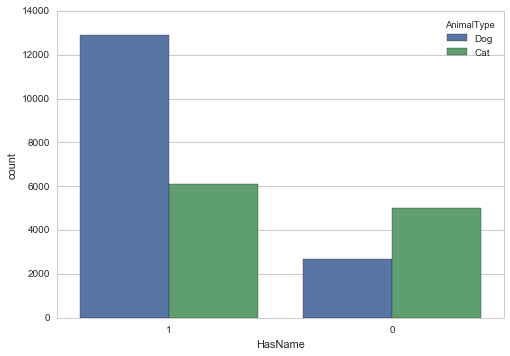

In [213]:
sns.countplot(x="HasName",hue="AnimalType",data=animals)

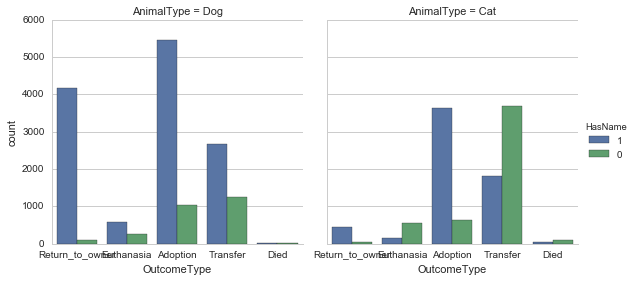

In [214]:
sns.factorplot(x="OutcomeType", hue="HasName",col="AnimalType", data=animals, kind="count");

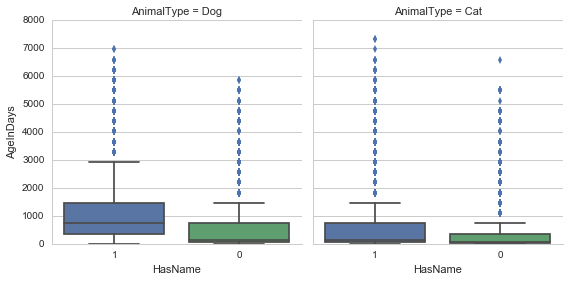

In [215]:
sns.factorplot(x="HasName", y="AgeInDays",col="AnimalType", data=animals, kind="box");

In [216]:
def is_mix_color(colr):
    colr = str(colr)
    if colr.find('/')>0:
        return 1
    elif colr.find(' ')>0:
        return 1
    else:
        return 0
    
animals['MixedColor'] = animals.Color.apply(is_mix_color)

#And now to the test set
animals_test['MixedColor'] = animals_test.Color.apply(is_mix_color)

In [217]:
print animals.head(5)

  AnimalID     Name      OutcomeType OutcomeSubtype AnimalType  \
0  A671945  Hambone  Return_to_owner            NaN        Dog   
1  A656520    Emily       Euthanasia      Suffering        Cat   
2  A686464   Pearce         Adoption         Foster        Dog   
3  A683430      NaN         Transfer        Partner        Cat   
4  A667013      NaN         Transfer        Partner        Dog   

                         Breed        Color  OutcomeYear  OutcomeMonth  \
0        Shetland Sheepdog Mix  Brown/White         2014             2   
1       Domestic Shorthair Mix  Cream Tabby         2013            10   
2                 Pit Bull Mix   Blue/White         2015             1   
3       Domestic Shorthair Mix   Blue Cream         2014             7   
4  Lhasa Apso/Miniature Poodle          Tan         2013            11   

   OutcomeDay  Sterilization     Sex  AgeInDays  Mix    BreedGroup  HasName  \
0          12              1    Male        365    1       Herding        1   


In [218]:
plt.figure()
g=sns.PairGrid(data=animals[["OutcomeType","AnimalType","OutcomeMonth","Sterilization","Sex","AgeInDays","Mix","HasName"]], hue="OutcomeType", dropna=True)
g = g.map_diag(sns.countplot)
g = g.map_offdiag(sns.stripplot, jitter=True)
#g.set(xticklabels=[])
#g.set_xticks(rotation=30)

In [219]:
lab_enc = preprocessing.LabelEncoder()
animals.Sex = lab_enc.fit_transform(animals.Sex)
animals.AnimalType = lab_enc.fit_transform(animals.AnimalType)
animals.OutcomeType = lab_enc.fit_transform(animals.OutcomeType)
#To convert back animals.Sex = lab_enc.inverse_transform(animals.Sex)

animals = animals.drop('AnimalID',1)
animals = animals.drop('OutcomeSubtype',1)
animals = animals.drop('Breed',1)
animals = animals.drop('BreedGroup',1)
animals = animals.drop('Name',1)
animals = animals.drop('Color',1)


#And now to the test set
lab_enc = preprocessing.LabelEncoder()
animals_test.Sex = lab_enc.fit_transform(animals_test.Sex)
animals_test.AnimalType = lab_enc.fit_transform(animals_test.AnimalType)


animals_test = animals_test.drop('ID',1)
animals_test = animals_test.drop('Breed',1)
animals_test = animals_test.drop('BreedGroup',1)
animals_test = animals_test.drop('Name',1)
animals_test = animals_test.drop('Color',1)


print animals.head(5)

   OutcomeType  AnimalType  OutcomeYear  OutcomeMonth  OutcomeDay  \
0            3           1         2014             2          12   
1            2           0         2013            10          13   
2            0           1         2015             1          31   
3            4           0         2014             7          11   
4            4           1         2013            11          15   

   Sterilization  Sex  AgeInDays  Mix  HasName  NameCount  MixedColor  
0              1    1        365    1        1          5           1  
1              1    0        365    1        1         16           1  
2              1    1        730    1        1          2           1  
3              0    1         21    1        0         17           1  
4              1    1        730    1        0         17           0  


In [220]:
def scale_all_features(df):
        
    features = list(df.columns)
    if 'OutcomeType' in features:
        features.remove('OutcomeType')
    df[features] = df[features].apply(lambda x: x/x.max(), axis=0)
    
scale_all_features(animals)
scale_all_features(animals_test)


In [ ]:
#Now Fit!

In [222]:
#Grid search for best params

X = animals.iloc[:, 1:]
y = animals.OutcomeType

rf = RandomForestClassifier(class_weight="balanced")
paramsRF = {'n_estimators':(500, 1000, 2000), 'criterion':("gini", "entropy"),'min_samples_split':(1,2,4),'min_samples_leaf':(1,2)}
gsRF = GridSearchCV(rf, paramsRF, n_jobs=-1)
gsRF.fit(X.values, y.values)

#Very slow, run if you have time on your hands
#et = ExtraTreesClassifier(class_weight="balanced")
#paramsET = {'n_estimators':(500, 1000, 2000), 'criterion':("gini", "entropy"),'min_samples_split':(1,2,3,4),'min_samples_leaf':(1,2,3,4) }
#gsET = GridSearchCV(rf, paramsET, n_jobs=-1)
#gsET.fit(X.values, y.values)
#gsET.best_params_
#gsET.best_score_

#gb = GradientBoostingClassifier()
#paramsGB = {'n_estimators':(500, 1000, 2000),'max_depth':(1,2,3,4),'min_samples_split':(1,2,3,4),'min_samples_leaf':(1,2,3,4) }
#gsGB = GridSearchCV(rf, paramsGB, n_jobs=-1)
#gsGB.fit(X.values, y.values)
#gsGB.best_params_
#gsGB.best_score_


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': (500, 1000, 2000), 'min_samples_split': (1, 2), 'criterion': ('gini', 'entropy'), 'min_samples_leaf': (1, 2)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [223]:
gsRF.best_score_

0.6346664671330764

In [224]:
gsRF.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 2000}

In [44]:
#Try out a few classifiers

alg_RFE = RandomForestClassifier(random_state=1, criterion='entropy',n_estimators=1000, min_samples_split=2, min_samples_leaf=1)
alg_ETE = ExtraTreesClassifier(random_state=1, criterion='entropy', n_estimators=1000, min_samples_split=2, min_samples_leaf=1)
#Run GradientBoosting with fewer trees because very slow
alg_GB = GradientBoostingClassifier(random_state=1, n_estimators=500, max_depth=3)

# Compute the accuracy score for all the cross validation folds.  
kf = StratifiedKFold(y, n_folds=5, random_state=1)
scores_RFE = cross_validation.cross_val_score(alg_RFE, X, y, cv=kf)
scores_ETE = cross_validation.cross_val_score(alg_ETE, X, y, cv=kf)
scores_GB = cross_validation.cross_val_score(alg_GB, X, y, cv=kf)

# Take the mean of the scores for each fold
print 'RFE', scores_RFE.mean()
print 'ETE', scores_ETE.mean()
print 'GB', scores_GB.mean()

#GradientBoosting works best, but still not great accr

RFE 0.632721633368
ETE 0.617606968371
GB 0.645890239902


In [42]:
#Try a voting classifier with the above. 
X = animals.iloc[:, 1:]
y = animals.OutcomeType

kf = StratifiedKFold(y, 5, random_state=1)
estimators = []
model1 = ExtraTreesClassifier(random_state=1, criterion='entropy', n_estimators=1000, min_samples_split=2, min_samples_leaf=1, n_jobs=-1)
estimators.append(('extra_trees', model1))
model2 = GradientBoostingClassifier(random_state=1, n_estimators=500, max_depth=3)
estimators.append(('gb', model2))
model3 = RandomForestClassifier(random_state=1, criterion='entropy',n_estimators=1000, min_samples_split=2, min_samples_leaf=1, n_jobs=-1)
estimators.append(('rf', model3))

# create the ensemble model
ensemble = VotingClassifier(estimators)
results = cross_validation.cross_val_score(ensemble, X, y, cv=kf)
print(results.mean())
#Scores did not improve. are the classifiers too simialar/correlated?

0.634928730373


In [58]:
# Perform feature selection

clf = GradientBoostingClassifier(random_state=1, n_estimators=500, max_depth=3)
clf = clf.fit(X, y)
fi = clf.feature_importances_

In [59]:
print fi

[ 0.04575015  0.06239401  0.14048143  0.21767363  0.0590989   0.01722517
  0.24965369  0.02486911  0.02359359  0.14273014  0.01653018]


In [51]:
list(X)

['AnimalType',
 'OutcomeYear',
 'OutcomeMonth',
 'OutcomeDay',
 'Sterilization',
 'Sex',
 'AgeInDays',
 'Mix',
 'HasName',
 'NameCount',
 'MixedColor']

In [ ]:
#Finally apply to test set, this will be the submission file.

X_test = animals_test.iloc[:, 1:]
y_test = animals.OutcomeType

clf = GradientBoostingClassifier(random_state=1, n_estimators=500, max_depth=3)

# Train the algorithm using all the training data
clf.fit(X, y)

# Make predictions using the test set.
predictions = clf.predict(animals_test)

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pandas.DataFrame({
        "ID": animals_test["ID"],
        "Outcome": predictions
    })